<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/master/notebooks/run_cellpose_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose with/without training

(thanks to Matteo Carandini for setting this up)

UPDATED DEC 2020 for TORCH VERSION cellpose v0.6

UPDATED NOV 2021 for cellpose / omnipose v0.7

## installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

Note that cellpose uses the latest version of numpy, so please click the "Restart runtime" button once the install completes.

In [1]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 6.8 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.72
    Uninstalling opencv-python-headless-4.7.0.72:
      Successfully uninstalled opencv-python-headless-4.7.0.72
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Check CUDA version and GPU

In [2]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
Wed Feb 26 16:48:41 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   53C    P2   111W / 350W |   2426MiB / 24576MiB |      7%      Default |
|                               |                      |                  N/A |
+---

import libraries and check GPU (the first time you import cellpose the models will download).

In [2]:
import numpy as np
import time, os, sys
import tifffile
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models, core

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();


>>> GPU activated? 1
2025-04-16 11:15:34,681 [INFO] WRITING LOG OUTPUT TO /home/xzhang/.cellpose/run.log
2025-04-16 11:15:34,681 [INFO] 
cellpose version: 	2.2 
platform:       	linux 
python version: 	3.9.12 
torch version:  	2.5.1+cu124


Download sample images

# load 3d dataset allencell

In [3]:
from natsort import natsorted
import tifffile
import glob
import os 

data_folder = "../../Nanolive_dataset/"
image_files = natsorted(glob.glob(data_folder + 'images/*.tiff'))
seg_files = natsorted(glob.glob(data_folder + 'labels/*.tiff'))
fold = 1
valid_img_files = [f for i,f in enumerate(image_files) if i%5 == fold-1]
valid_seg_files = [f for i,f in enumerate(seg_files) if i%5 == fold-1]

test_img_files = [f for i,f in enumerate(image_files) if i%5 == fold]
test_seg_files = [f for i,f in enumerate(seg_files) if i%5 == fold]

train_img_files = [f for f in image_files if f not in valid_img_files and f not in test_img_files]
train_seg_files = [f for f in seg_files if f not in valid_seg_files and f not in test_seg_files]


print(len(train_img_files), len(train_seg_files), len(valid_img_files), len(valid_seg_files), len(test_img_files), len(test_seg_files))
# print(train_img_files,valid_img_files)


6 6 2 2 2 2


# training

In [45]:


# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from swincell.utils.utils import matching,batch_matching
from cellpose import models
initial_model = "cyto" #@param ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch']
# model_name = "allen_2d" #@param {type:"string"}
# train_dir ='./allen_train/'
model_name = f"Nanolive_Cellpose_3D_Training_fold{fold}"

train_dir = data_folder
# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100#@param {type:"number"}


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}


if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  learning_rate = 0.1 
  weight_decay = 0.0001
  
#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'cellpose_models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")
  




Default advanced parameters enabled


In [7]:
  # start logger (to see training across epochs)
# logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
# model already defined
# model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
# set channels

# get files
#cellpose load all the training data at the same time
train_data = []
train_labels = []
test_data = []
test_labels = []

for i in range(len(train_img_files)):
# for i in range(1):
        train_data_3d = tifffile.imread(train_img_files[i])
        train_labels_3d = tifffile.imread(train_seg_files[i])

        from skimage import measure
        train_labels_3d =  measure.label(train_labels_3d)  # semantic label ---> instance label

        #--------------use 2d slices to train the model----------------
        # use the slice as training data if mask is not empty in the slice
        train_img_idx_z = [idx_z for idx_z,slice in enumerate(train_labels_3d) if np.sum(slice)>1] 
        # add xy plane (different z slice) training data:
        train_data_3d_z = train_data_3d[train_img_idx_z]
        train_labels_3d_z = train_labels_3d[train_img_idx_z]
        
        for slice in train_data_3d_z:
                train_data.append(slice)
        for slice in train_labels_3d_z:
                train_labels.append(slice)
        # add x slice training data:
        

        # Get slices along the x-dimension
        train_img_idx_x = [idx_x for idx_x in range(train_data_3d.shape[1]) if np.sum(train_labels_3d[:, idx_x, :]) > 1]
        train_data_3d_x = train_data_3d[:, train_img_idx_x, :]
        train_labels_3d_x = train_labels_3d[:, train_img_idx_x, :]

        # Add x-plane slices to training data
        for slice in train_data_3d_x.transpose(1, 0, 2):
                train_data.append(slice)
        for slice in train_labels_3d_x.transpose(1, 0, 2):
                train_labels.append(slice)

        # Get slices along the y-dimension
        train_img_idx_y = [idx_y for idx_y in range(train_data_3d.shape[2]) if np.sum(train_labels_3d[:, :, idx_y]) > 1]
        train_data_3d_y = train_data_3d[:, :, train_img_idx_y]
        train_labels_3d_y = train_labels_3d[:, :, train_img_idx_y]

        # Add y-plane slices to training data
        for slice in train_data_3d_y.transpose(2, 0, 1):  # Transpose to iterate over y-plane slices
                train_data.append(slice)
        for slice in train_labels_3d_y.transpose(2, 0, 1):
                train_labels.append(slice)
    
        # train_data.append([slice for slice in train_data_3d])
        # train_labels.append([slice for slice in train_labels_3d])
for i in range(len(valid_img_files)):
# for i in range(1):       
    test_data_3d = tifffile.imread(valid_img_files[i])
    test_labels_3d = tifffile.imread(valid_seg_files[i])
    from skimage import measure
    test_labels_3d =  measure.label(test_labels_3d) 
# semantic label ---> instance label
    test_img_idx_z = [idx for idx,slice in enumerate(test_labels_3d) if np.sum(slice)>1] 

    test_data_3d_z = test_data_3d[test_img_idx_z]
    test_labels_3d_z = test_labels_3d[test_img_idx_z]
     
    for slice in test_data_3d_z:
            test_data.append(slice)
    for slice in test_labels_3d_z:
            test_labels.append(slice)
    # add x slice testing data:
    
    for slice in test_data_3d:
            test_data.append(slice)
    for slice in test_labels_3d:
            test_labels.append(slice)
    
    # Get slices along the x-dimension
    test_img_idx_x = [idx_x for idx_x in range(test_data_3d.shape[1]) if np.sum(test_labels_3d[:, idx_x, :]) > 1]
    test_data_3d_x = test_data_3d[:, test_img_idx_x, :]
    test_labels_3d_x = test_labels_3d[:, test_img_idx_x, :]
    
    # Add x-plane slices to testing data
    for slice in test_data_3d_x.transpose(1, 0, 2):
            test_data.append(slice)
    for slice in test_labels_3d_x.transpose(1, 0, 2):
            test_labels.append(slice)
    
    # Get slices along the y-dimension
    test_img_idx_y = [idx_y for idx_y in range(test_data_3d.shape[2]) if np.sum(test_labels_3d[:, :, idx_y]) > 1]
    test_data_3d_y = test_data_3d[:, :, test_img_idx_y]
    test_labels_3d_y = test_labels_3d[:, :, test_img_idx_y]
    
    # Add y-plane slices to testing data
    for slice in test_data_3d_y.transpose(2, 0, 1):  # Transpose to iterate over y-plane slices
            test_data.append(slice)
    for slice in test_labels_3d_y.transpose(2, 0, 1):
            test_labels.append(slice)
    # test_data.append(slice for slice in test_data_3d)
    # test_labels.append(slice for slice in test_labels_3d)
#---------------------------------------------------------------
# 
print(len(train_data),len(test_data))
print('train data shape',train_data[0].shape)

new_model_path = model.train(train_data, train_labels, 
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=[0], 
                              save_path=model_path, 
                              n_epochs=n_epochs,
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay, 
                              nimg_per_epoch=16,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.diam_labels.copy()

2025-02-26 16:49:14,939 [INFO] >> cyto << model set to be used
2025-02-26 16:49:14,951 [INFO] ** TORCH CUDA version installed and working. **
2025-02-26 16:49:14,952 [INFO] >>>> using GPU
2025-02-26 16:49:15,075 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
6297 2143
train data shape (512, 512)
2025-02-26 16:49:52,185 [INFO] computing flows for labels


100%|██████████| 6297/6297 [04:16<00:00, 24.55it/s]


2025-02-26 16:54:12,221 [INFO] computing flows for labels


  2%|▏         | 41/2143 [00:02<01:54, 18.43it/s]

2025-02-26 16:54:15,448 [WARNING] empty masks!
2025-02-26 16:54:15,449 [WARNING] empty masks!
2025-02-26 16:54:15,449 [WARNING] empty masks!
2025-02-26 16:54:15,450 [WARNING] empty masks!
2025-02-26 16:54:15,450 [WARNING] empty masks!
2025-02-26 16:54:15,451 [WARNING] empty masks!
2025-02-26 16:54:15,451 [WARNING] empty masks!
2025-02-26 16:54:15,452 [WARNING] empty masks!
2025-02-26 16:54:15,452 [WARNING] empty masks!
2025-02-26 16:54:15,452 [WARNING] empty masks!
2025-02-26 16:54:15,453 [WARNING] empty masks!
2025-02-26 16:54:15,453 [WARNING] empty masks!
2025-02-26 16:54:15,454 [WARNING] empty masks!
2025-02-26 16:54:15,454 [WARNING] empty masks!
2025-02-26 16:54:15,455 [WARNING] empty masks!
2025-02-26 16:54:15,455 [WARNING] empty masks!
2025-02-26 16:54:15,455 [WARNING] empty masks!
2025-02-26 16:54:15,456 [WARNING] empty masks!
2025-02-26 16:54:15,456 [WARNING] empty masks!
2025-02-26 16:54:15,456 [WARNING] empty masks!
2025-02-26 16:54:15,457 [WARNING] empty masks!


  5%|▍         | 106/2143 [00:05<01:44, 19.44it/s]

2025-02-26 16:54:18,404 [WARNING] empty masks!
2025-02-26 16:54:18,405 [WARNING] empty masks!
2025-02-26 16:54:18,405 [WARNING] empty masks!
2025-02-26 16:54:18,406 [WARNING] empty masks!
2025-02-26 16:54:18,406 [WARNING] empty masks!
2025-02-26 16:54:18,406 [WARNING] empty masks!
2025-02-26 16:54:18,407 [WARNING] empty masks!
2025-02-26 16:54:18,407 [WARNING] empty masks!
2025-02-26 16:54:18,407 [WARNING] empty masks!
2025-02-26 16:54:18,408 [WARNING] empty masks!
2025-02-26 16:54:18,408 [WARNING] empty masks!
2025-02-26 16:54:18,408 [WARNING] empty masks!
2025-02-26 16:54:18,409 [WARNING] empty masks!
2025-02-26 16:54:18,409 [WARNING] empty masks!
2025-02-26 16:54:18,410 [WARNING] empty masks!
2025-02-26 16:54:18,410 [WARNING] empty masks!
2025-02-26 16:54:18,410 [WARNING] empty masks!
2025-02-26 16:54:18,411 [WARNING] empty masks!
2025-02-26 16:54:18,411 [WARNING] empty masks!
2025-02-26 16:54:18,411 [WARNING] empty masks!
2025-02-26 16:54:18,412 [WARNING] empty masks!
2025-02-26 16

 48%|████▊     | 1027/2143 [00:38<00:48, 22.84it/s]

2025-02-26 16:54:50,853 [WARNING] empty masks!
2025-02-26 16:54:50,854 [WARNING] empty masks!


 48%|████▊     | 1034/2143 [00:38<00:32, 33.77it/s]

2025-02-26 16:54:50,864 [WARNING] empty masks!
2025-02-26 16:54:50,865 [WARNING] empty masks!
2025-02-26 16:54:50,865 [WARNING] empty masks!
2025-02-26 16:54:50,866 [WARNING] empty masks!
2025-02-26 16:54:50,866 [WARNING] empty masks!
2025-02-26 16:54:50,867 [WARNING] empty masks!
2025-02-26 16:54:50,867 [WARNING] empty masks!
2025-02-26 16:54:50,867 [WARNING] empty masks!
2025-02-26 16:54:50,868 [WARNING] empty masks!
2025-02-26 16:54:50,868 [WARNING] empty masks!
2025-02-26 16:54:50,869 [WARNING] empty masks!
2025-02-26 16:54:50,869 [WARNING] empty masks!
2025-02-26 16:54:50,870 [WARNING] empty masks!


 52%|█████▏    | 1108/2143 [00:42<00:41, 25.08it/s]

2025-02-26 16:54:54,864 [WARNING] empty masks!
2025-02-26 16:54:54,864 [WARNING] empty masks!
2025-02-26 16:54:54,865 [WARNING] empty masks!
2025-02-26 16:54:54,865 [WARNING] empty masks!
2025-02-26 16:54:54,866 [WARNING] empty masks!
2025-02-26 16:54:54,866 [WARNING] empty masks!
2025-02-26 16:54:54,866 [WARNING] empty masks!
2025-02-26 16:54:54,867 [WARNING] empty masks!
2025-02-26 16:54:54,867 [WARNING] empty masks!
2025-02-26 16:54:54,868 [WARNING] empty masks!
2025-02-26 16:54:54,868 [WARNING] empty masks!
2025-02-26 16:54:54,868 [WARNING] empty masks!
2025-02-26 16:54:54,869 [WARNING] empty masks!
2025-02-26 16:54:54,869 [WARNING] empty masks!
2025-02-26 16:54:54,870 [WARNING] empty masks!
2025-02-26 16:54:54,870 [WARNING] empty masks!


100%|██████████| 2143/2143 [01:23<00:00, 25.76it/s]


2025-02-26 16:55:36,285 [WARNING] 3259 train images with number of masks less than min_train_masks (5), removing from train set
2025-02-26 16:55:39,534 [INFO] >>>> median diameter set to = 30
2025-02-26 16:55:39,535 [INFO] >>>> mean of training label mask diameters (saved to model) 41.368
2025-02-26 16:55:39,535 [INFO] >>>> training network with 2 channel input <<<<
2025-02-26 16:55:39,536 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-02-26 16:55:39,536 [INFO] >>>> ntrain = 3038, ntest = 2143
2025-02-26 16:55:39,536 [INFO] >>>> nimg_per_epoch = 3038
2025-02-26 16:56:26,207 [INFO] Epoch 0, Time 46.7s, Loss 1.7807, Loss Test 1.7018, LR 0.0000
2025-02-26 16:57:01,954 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_3D_Training_fold1
2025-02-26 16:59:35,003 [INFO] Epoch 5, Time 235.5s, Loss 0.3338, Loss Test 0.1201, LR 0.0556
2025-02-26 17:02:43,013 [INFO] Epoch 10, Time 423.5s, Loss 0.2713, Loss Test 0.1116, LR 0.1000

In [83]:
import numpy as np
import tifffile
from skimage import measure

# Helper functions to train Cellpose model in orthogonal planes

def load_and_label_image(image_path, label_path):
    """
    Load a 3D image and its corresponding label, then convert the label to instance labels.

    Parameters:
    - image_path: str, path to the 3D image file.
    - label_path: str, path to the 3D label file.

    Returns:
    - image_3d: ndarray, the loaded 3D image.
    - labels_3d: ndarray, the instance-labeled 3D labels.
    """
    image_3d = tifffile.imread(image_path)
    labels_3d = tifffile.imread(label_path)
    labels_3d = measure.label(labels_3d)  # Convert semantic labels to instance labels
    return image_3d, labels_3d

def extract_slices(image_3d, labels_3d, axis):
    """
    Extract non-empty 2D slices from a 3D image along a specified axis.

    Parameters:
    - image_3d: ndarray, the 3D image.
    - labels_3d: ndarray, the 3D labels.
    - axis: int, the axis along which to slice (0 for XY, 1 for YZ, 2 for XZ).

    Returns:
    - slices: list of ndarrays, the extracted 2D image slices.
    - slice_labels: list of ndarrays, the corresponding 2D label slices.
    """
    slices = []
    slice_labels = []
    # Iterate over the specified axis
    for idx in range(image_3d.shape[axis]):
        if axis == 0:  # XY plane
            img_slice = image_3d[idx, :, :]
            label_slice = labels_3d[idx, :, :]
        elif axis == 1:  # YZ plane
            img_slice = image_3d[:, idx, :]
            label_slice = labels_3d[:, idx, :]
        elif axis == 2:  # XZ plane
            img_slice = image_3d[:, :, idx]
            label_slice = labels_3d[:, :, idx]
        # Add slice if the label slice is not empty
        if np.sum(label_slice) > 1:
            slices.append(img_slice)
            slice_labels.append(label_slice)
    return slices, slice_labels

def process_dataset(image_files, label_files, train_2D_only=False):
    """
    Process a list of 3D images and their labels to extract 2D slices for training.

    Parameters:
    - image_files: list of str, paths to the 3D image files.
    - label_files: list of str, paths to the 3D label files.
    - train_2D_only: if true, do 2D training, if false, perform 2.5D training
    Returns:
    - data_slices: list of ndarrays, the extracted 2D image slices.
    - label_slices: list of ndarrays, the corresponding 2D label slices.
    """
    data_slices = []
    label_slices = []
    for img_path, lbl_path in zip(image_files, label_files):
        image_3d, labels_3d = load_and_label_image(img_path, lbl_path)
        if train_2D_only:
            for axis in range(1):  # Iterate over axes 0 (XY)
                slices, slice_labels = extract_slices(image_3d, labels_3d, axis)
                data_slices.extend(slices)
                label_slices.extend(slice_labels)
        else:
            for axis in range(3):  # Iterate over axes 0 (XY), 1 (YZ), 2 (XZ)
                slices, slice_labels = extract_slices(image_3d, labels_3d, axis)
                data_slices.extend(slices)
                label_slices.extend(slice_labels)

    return data_slices, label_slices



def split_dataset_5fold(data_folder, fold):
    """
    Splits the dataset into training, validation, and test sets based on the specified fold.

    Parameters:
    - data_folder (str): Path to the dataset folder containing 'images' and 'labels' subdirectories.
    - fold (int): The fold number (0 through 4) determining the split.

    Returns:
    - train_img_files (list): List of training image file paths.
    - train_seg_files (list): List of training segmentation label file paths.
    - valid_img_files (list): List of validation image file paths.
    - valid_seg_files (list): List of validation segmentation label file paths.
    - test_img_files (list): List of test image file paths.
    - test_seg_files (list): List of test segmentation label file paths.
    """
    # Retrieve and sort image and label file paths
    image_files = natsorted(glob.glob(f'{data_folder}/images/*.tiff'))
    seg_files = natsorted(glob.glob(f'{data_folder}/labels/*.tiff'))

    # Ensure the fold value is within the valid range
    if fold < 0 or fold > 4:
        raise ValueError("Fold must be an integer between 0 and 4.")

    # Determine validation and test sets based on the fold
    valid_img_files = [f for i, f in enumerate(image_files) if i % 5 == fold]
    valid_seg_files = [f for i, f in enumerate(seg_files) if i % 5 == fold]

    test_img_files = [f for i, f in enumerate(image_files) if i % 5 == (fold + 1) % 5]
    test_seg_files = [f for i, f in enumerate(seg_files) if i % 5 == (fold + 1) % 5]

    # Remaining files are used for training
    train_img_files = [f for f in image_files if f not in valid_img_files and f not in test_img_files]
    train_seg_files = [f for f in seg_files if f not in valid_seg_files and f not in test_seg_files]

    return train_img_files, train_seg_files, valid_img_files, valid_seg_files, test_img_files, test_seg_files





# Train 2.5D Cellpose 5 Fold cross validation

In [84]:
data_folder = "../../Nanolive_dataset/"
for fold in range(0,5):
    
    train_img_files, train_seg_files, valid_img_files, valid_seg_files, test_img_files, test_seg_files = split_dataset_5fold(data_folder, fold)
    
    train_data, train_labels = process_dataset(train_img_files, train_seg_files)
    valid_data, valid_labels = process_dataset(valid_img_files, valid_seg_files)

    # print(len(train_data),len(train_labels))
    model_name = f"Nanolive_Cellpose_3D_Training_fold{fold}_v2"

  
    #here we check that no model with the same name already exist, if so delete
    model_path = train_dir + 'cellpose_models/'
    if os.path.exists(model_path+'/'+model_name):
        print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

    model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)
    
    new_model_path = model.train(train_data, train_labels, 
                              test_data=valid_data,
                              test_labels=valid_labels,  # the test data is actually the validation data in Cellpose
                              channels=[0], 
                              save_path=model_path, 
                              n_epochs=n_epochs,
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay, 
                              nimg_per_epoch=16,
                              model_name=model_name)

2025-04-17 14:30:02,657 [INFO] >> cyto << model set to be used
2025-04-17 14:30:02,672 [INFO] ** TORCH CUDA version installed and working. **
2025-04-17 14:30:02,672 [INFO] >>>> using GPU
2025-04-17 14:30:02,763 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-04-17 14:30:29,815 [INFO] computing flows for labels


100%|██████████| 6297/6297 [09:03<00:00, 11.59it/s]


2025-04-17 14:39:36,817 [INFO] computing flows for labels


100%|██████████| 1951/1951 [02:11<00:00, 14.82it/s]


2025-04-17 14:41:49,419 [WARNING] 791 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-17 14:41:53,279 [INFO] >>>> median diameter set to = 30
2025-04-17 14:41:53,279 [INFO] >>>> mean of training label mask diameters (saved to model) 21.613
2025-04-17 14:41:53,280 [INFO] >>>> training network with 2 channel input <<<<
2025-04-17 14:41:53,280 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-04-17 14:41:53,280 [INFO] >>>> ntrain = 5506, ntest = 1951
2025-04-17 14:41:53,280 [INFO] >>>> nimg_per_epoch = 5506
2025-04-17 14:43:06,551 [INFO] Epoch 0, Time 73.3s, Loss 1.8808, Loss Test 2.1226, LR 0.0000
2025-04-17 14:44:10,994 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_3D_Training_fold0_v2
2025-04-17 14:48:39,573 [INFO] Epoch 5, Time 406.3s, Loss 0.3284, Loss Test 0.2666, LR 0.0556
2025-04-17 14:54:11,045 [INFO] Epoch 10, Time 737.8s, Loss 0.2982, Loss Test 0.2616, LR 0.10

100%|██████████| 6090/6090 [07:22<00:00, 13.76it/s]


2025-04-17 16:38:47,514 [INFO] computing flows for labels


100%|██████████| 2202/2202 [03:18<00:00, 11.10it/s]


2025-04-17 16:42:06,937 [WARNING] 1141 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-17 16:42:10,743 [INFO] >>>> median diameter set to = 30
2025-04-17 16:42:10,743 [INFO] >>>> mean of training label mask diameters (saved to model) 23.223
2025-04-17 16:42:10,744 [INFO] >>>> training network with 2 channel input <<<<
2025-04-17 16:42:10,744 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-04-17 16:42:10,744 [INFO] >>>> ntrain = 4949, ntest = 2202
2025-04-17 16:42:10,744 [INFO] >>>> nimg_per_epoch = 4949
2025-04-17 16:43:18,469 [INFO] Epoch 0, Time 67.7s, Loss 1.8599, Loss Test 2.1108, LR 0.0000
2025-04-17 16:44:15,744 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_3D_Training_fold1_v2
2025-04-17 16:48:17,895 [INFO] Epoch 5, Time 367.2s, Loss 0.3014, Loss Test 0.2580, LR 0.0556
2025-04-17 16:53:16,271 [INFO] Epoch 10, Time 665.5s, Loss 0.2749, Loss Test 0.2546, LR 0.1

100%|██████████| 6199/6199 [08:37<00:00, 11.98it/s]


2025-04-17 18:29:41,015 [INFO] computing flows for labels


100%|██████████| 2158/2158 [03:54<00:00,  9.19it/s]


2025-04-17 18:33:36,824 [WARNING] 877 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-17 18:33:40,706 [INFO] >>>> median diameter set to = 30
2025-04-17 18:33:40,707 [INFO] >>>> mean of training label mask diameters (saved to model) 22.760
2025-04-17 18:33:40,707 [INFO] >>>> training network with 2 channel input <<<<
2025-04-17 18:33:40,708 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-04-17 18:33:40,708 [INFO] >>>> ntrain = 5322, ntest = 2158
2025-04-17 18:33:40,708 [INFO] >>>> nimg_per_epoch = 5322
2025-04-17 18:34:47,476 [INFO] Epoch 0, Time 66.8s, Loss 1.9393, Loss Test 2.1141, LR 0.0000
2025-04-17 18:35:44,776 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_3D_Training_fold2_v2
2025-04-17 18:39:43,896 [INFO] Epoch 5, Time 363.2s, Loss 0.2874, Loss Test 0.3747, LR 0.0556
2025-04-17 18:44:40,364 [INFO] Epoch 10, Time 659.7s, Loss 0.2644, Loss Test 0.3969, LR 0.10

100%|██████████| 6311/6311 [09:12<00:00, 11.42it/s]


2025-04-17 20:20:57,625 [INFO] computing flows for labels


100%|██████████| 2093/2093 [02:12<00:00, 15.78it/s]


2025-04-17 20:23:11,213 [WARNING] 689 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-17 20:23:15,258 [INFO] >>>> median diameter set to = 30
2025-04-17 20:23:15,259 [INFO] >>>> mean of training label mask diameters (saved to model) 21.612
2025-04-17 20:23:15,259 [INFO] >>>> training network with 2 channel input <<<<
2025-04-17 20:23:15,260 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-04-17 20:23:15,260 [INFO] >>>> ntrain = 5622, ntest = 2093
2025-04-17 20:23:15,260 [INFO] >>>> nimg_per_epoch = 5622
2025-04-17 20:24:25,023 [INFO] Epoch 0, Time 69.8s, Loss 1.9443, Loss Test 1.5900, LR 0.0000
2025-04-17 20:25:25,555 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_3D_Training_fold3_v2
2025-04-17 20:29:37,166 [INFO] Epoch 5, Time 381.9s, Loss 0.3227, Loss Test 0.2508, LR 0.0556
2025-04-17 20:34:49,748 [INFO] Epoch 10, Time 694.5s, Loss 0.2946, Loss Test 0.2532, LR 0.10

100%|██████████| 6453/6453 [09:11<00:00, 11.69it/s]


2025-04-17 22:15:52,539 [INFO] computing flows for labels


100%|██████████| 2046/2046 [02:57<00:00, 11.50it/s]


2025-04-17 22:18:51,437 [WARNING] 711 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-17 22:18:55,424 [INFO] >>>> median diameter set to = 30
2025-04-17 22:18:55,424 [INFO] >>>> mean of training label mask diameters (saved to model) 21.573
2025-04-17 22:18:55,425 [INFO] >>>> training network with 2 channel input <<<<
2025-04-17 22:18:55,425 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-04-17 22:18:55,425 [INFO] >>>> ntrain = 5742, ntest = 2046
2025-04-17 22:18:55,425 [INFO] >>>> nimg_per_epoch = 5742
2025-04-17 22:20:06,335 [INFO] Epoch 0, Time 70.9s, Loss 1.9111, Loss Test 1.9605, LR 0.0000
2025-04-17 22:21:08,397 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_3D_Training_fold4_v2
2025-04-17 22:25:26,000 [INFO] Epoch 5, Time 390.6s, Loss 0.3215, Loss Test 0.2664, LR 0.0556
2025-04-17 22:30:44,392 [INFO] Epoch 10, Time 709.0s, Loss 0.2917, Loss Test 0.2714, LR 0.10

# Train 2D Cellpose 5 Fold

In [46]:
data_folder = "../../Nanolive_dataset/"
for fold in range(0,5):
    
    train_img_files, train_seg_files, valid_img_files, valid_seg_files, test_img_files, test_seg_files = split_dataset_5fold(data_folder, fold)
    
    train_data, train_labels = process_dataset(train_img_files, train_seg_files,train_2D_only=True)
    valid_data, valid_labels = process_dataset(valid_img_files, valid_seg_files,train_2D_only=True)

    # print(len(train_data),len(train_labels))
    model_name = f"Nanolive_Cellpose_2D_Training_fold{fold}"

  
    #here we check that no model with the same name already exist, if so delete
    model_path = train_dir + 'cellpose_models/'
    if os.path.exists(model_path+'/'+model_name):
        print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

    model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)
    
    new_model_path = model.train(train_data, train_labels, 
                              test_data=valid_data,
                              test_labels=valid_labels,  # the test data is actually the validation data in Cellpose
                              channels=[0], 
                              save_path=model_path, 
                              n_epochs=n_epochs,
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay, 
                              nimg_per_epoch=16,
                              model_name=model_name)

2025-04-16 16:57:09,116 [INFO] >> cyto << model set to be used
2025-04-16 16:57:09,128 [INFO] ** TORCH CUDA version installed and working. **
2025-04-16 16:57:09,128 [INFO] >>>> using GPU
2025-04-16 16:57:09,220 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-04-16 16:57:14,875 [INFO] computing flows for labels


100%|██████████| 385/385 [00:25<00:00, 15.07it/s]


2025-04-16 16:57:41,056 [INFO] computing flows for labels


100%|██████████| 108/108 [00:07<00:00, 15.04it/s]


2025-04-16 16:57:48,386 [WARNING] 87 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-16 16:57:49,308 [INFO] >>>> median diameter set to = 30
2025-04-16 16:57:49,309 [INFO] >>>> mean of training label mask diameters (saved to model) 57.618
2025-04-16 16:57:49,309 [INFO] >>>> training network with 2 channel input <<<<
2025-04-16 16:57:49,309 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-04-16 16:57:49,310 [INFO] >>>> ntrain = 298, ntest = 108
2025-04-16 16:57:49,310 [INFO] >>>> nimg_per_epoch = 298
2025-04-16 16:57:53,993 [INFO] Epoch 0, Time  4.7s, Loss 1.1211, Loss Test 0.8662, LR 0.0000
2025-04-16 16:57:57,724 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_2D_Training_fold0
2025-04-16 16:58:13,603 [INFO] Epoch 5, Time 24.3s, Loss 0.5324, Loss Test 0.3256, LR 0.0556
2025-04-16 16:58:33,189 [INFO] Epoch 10, Time 43.9s, Loss 0.4029, Loss Test 0.3093, LR 0.1000
2025-0

100%|██████████| 372/372 [00:23<00:00, 15.85it/s]


2025-04-16 17:04:50,261 [INFO] computing flows for labels


100%|██████████| 154/154 [00:10<00:00, 14.67it/s]


2025-04-16 17:05:00,954 [WARNING] 71 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-16 17:05:01,968 [INFO] >>>> median diameter set to = 30
2025-04-16 17:05:01,969 [INFO] >>>> mean of training label mask diameters (saved to model) 58.713
2025-04-16 17:05:01,969 [INFO] >>>> training network with 2 channel input <<<<
2025-04-16 17:05:01,969 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-04-16 17:05:01,969 [INFO] >>>> ntrain = 301, ntest = 154
2025-04-16 17:05:01,970 [INFO] >>>> nimg_per_epoch = 301
2025-04-16 17:05:06,673 [INFO] Epoch 0, Time  4.7s, Loss 1.0510, Loss Test 1.3592, LR 0.0000
2025-04-16 17:05:10,451 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_2D_Training_fold1
2025-04-16 17:05:26,513 [INFO] Epoch 5, Time 24.5s, Loss 0.3944, Loss Test 0.3989, LR 0.0556
2025-04-16 17:05:46,321 [INFO] Epoch 10, Time 44.4s, Loss 0.3065, Loss Test 0.4353, LR 0.1000
2025-0

100%|██████████| 365/365 [00:24<00:00, 15.04it/s]


2025-04-16 17:11:52,016 [INFO] computing flows for labels


100%|██████████| 121/121 [00:08<00:00, 14.68it/s]


2025-04-16 17:12:00,428 [WARNING] 71 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-16 17:12:01,364 [INFO] >>>> median diameter set to = 30
2025-04-16 17:12:01,364 [INFO] >>>> mean of training label mask diameters (saved to model) 60.433
2025-04-16 17:12:01,365 [INFO] >>>> training network with 2 channel input <<<<
2025-04-16 17:12:01,365 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-04-16 17:12:01,365 [INFO] >>>> ntrain = 294, ntest = 121
2025-04-16 17:12:01,365 [INFO] >>>> nimg_per_epoch = 294
2025-04-16 17:12:05,567 [INFO] Epoch 0, Time  4.2s, Loss 1.2422, Loss Test 1.0774, LR 0.0000
2025-04-16 17:12:09,037 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_2D_Training_fold2
2025-04-16 17:12:23,657 [INFO] Epoch 5, Time 22.3s, Loss 0.4830, Loss Test 0.8832, LR 0.0556
2025-04-16 17:12:41,725 [INFO] Epoch 10, Time 40.4s, Loss 0.3726, Loss Test 0.8885, LR 0.1000
2025-0

100%|██████████| 383/383 [00:25<00:00, 14.89it/s]


2025-04-16 17:18:33,724 [INFO] computing flows for labels


100%|██████████| 161/161 [00:09<00:00, 16.80it/s]


2025-04-16 17:18:43,518 [WARNING] 80 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-16 17:18:44,558 [INFO] >>>> median diameter set to = 30
2025-04-16 17:18:44,558 [INFO] >>>> mean of training label mask diameters (saved to model) 58.750
2025-04-16 17:18:44,559 [INFO] >>>> training network with 2 channel input <<<<
2025-04-16 17:18:44,559 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-04-16 17:18:44,559 [INFO] >>>> ntrain = 303, ntest = 161
2025-04-16 17:18:44,560 [INFO] >>>> nimg_per_epoch = 303
2025-04-16 17:18:49,043 [INFO] Epoch 0, Time  4.5s, Loss 1.2683, Loss Test 0.8886, LR 0.0000
2025-04-16 17:18:52,613 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_2D_Training_fold3
2025-04-16 17:19:07,886 [INFO] Epoch 5, Time 23.3s, Loss 0.5674, Loss Test 0.2317, LR 0.0556
2025-04-16 17:19:26,717 [INFO] Epoch 10, Time 42.2s, Loss 0.4438, Loss Test 0.2089, LR 0.1000
2025-0

100%|██████████| 436/436 [00:28<00:00, 15.46it/s]


2025-04-16 17:25:33,424 [INFO] computing flows for labels


100%|██████████| 103/103 [00:06<00:00, 15.09it/s]


2025-04-16 17:25:40,399 [WARNING] 120 train images with number of masks less than min_train_masks (5), removing from train set
2025-04-16 17:25:41,341 [INFO] >>>> median diameter set to = 30
2025-04-16 17:25:41,342 [INFO] >>>> mean of training label mask diameters (saved to model) 57.028
2025-04-16 17:25:41,342 [INFO] >>>> training network with 2 channel input <<<<
2025-04-16 17:25:41,342 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2025-04-16 17:25:41,343 [INFO] >>>> ntrain = 316, ntest = 103
2025-04-16 17:25:41,343 [INFO] >>>> nimg_per_epoch = 316
2025-04-16 17:25:45,626 [INFO] Epoch 0, Time  4.3s, Loss 1.2832, Loss Test 1.1256, LR 0.0000
2025-04-16 17:25:49,337 [INFO] saving network parameters to ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_2D_Training_fold4
2025-04-16 17:26:04,819 [INFO] Epoch 5, Time 23.5s, Loss 0.5673, Loss Test 0.4877, LR 0.0556
2025-04-16 17:26:24,004 [INFO] Epoch 10, Time 42.7s, Loss 0.4255, Loss Test 0.5013, LR 0.1000
2025-

## run cellpose after training

There are two ways to run cellpose in 3D, this cell shows both, choose which one works best for you.

First way: computes flows from 2D slices and combines into 3D flows to create masks



## prediction with pretrained models 2.5d models, and save masks

In [85]:
from cellpose import models, metrics
import tifffile


# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
for fold in range(0,5):
    
    train_img_files, train_seg_files, valid_img_files, valid_seg_files, test_img_files, test_seg_files = split_dataset_5fold(data_folder, fold)
    

    model_name = f"Nanolive_Cellpose_3D_Training_fold{fold}_v2"

  
    #here we check that no model with the same name already exist, if so delete
    model_path = train_dir + 'cellpose_models/models'

    model = models.CellposeModel(gpu=use_GPU, pretrained_model = model_path +f"Nanolive_Cellpose_3D_Training_fold{fold}")

    # test different parameters
    dia_list = [50,60,70]
    thre_list = [0.2,0.3,0.4]

    for thre in thre_list:
        for dia in dia_list:
    
            for file,mask in zip(test_img_files,test_seg_files):
                img = tifffile.imread(file)
                # gt = tifffile.imread(mask)
                file_name=os.path.basename(file)
                # img_3D = imgs[-1]

                # * with 3D you have to set the diameter manually (no auto detect) *

                ### TWO WAYS TO RUN CELLPOSE IN 3D

                # 1. computes flows from 2D slices and combines into 3D flows to create masks, skipped due to low accuracy
                # print('running cellpose 2D slice flows => masks')
                # 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
                print('running cellpose 2D + stitching masks')
                masks_stitched_after_training, flows_stitched, styles_stitched= model.eval(img, channels=[0,0], diameter=dia, do_3D=False, stitch_threshold=thre)
                #average_precision returns [AP,TP,FP,FN]
                
                for i in range(1,2):  #save flows??? : flow[1] = xy flow, flow[2] =cell prob, flow[3]final pixel location
                    tifffile.imwrite(data_folder +'results_2p5d_cellpose_v2/flows_'+str(i) +'_' + file_name.split('.')[0] +'_thre_'+str(thre)+ '_dia_' + str(dia) + '.tiff', flows_stitched[i])

                tifffile.imwrite(data_folder +'results_2p5d_cellpose_v2/mask_' + file_name.split('.')[0] +'_thre_'+str(thre)+ '_dia_' + str(dia) + '.tiff', masks_stitched_after_training)
            


2025-04-18 00:04:00,556 [WARNING] pretrained model has incorrect path
2025-04-18 00:04:00,557 [INFO] >> cyto << model set to be used
2025-04-18 00:04:00,557 [INFO] ** TORCH CUDA version installed and working. **
2025-04-18 00:04:00,558 [INFO] >>>> using GPU
2025-04-18 00:04:00,658 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
running cellpose 2D + stitching masks
2025-04-18 00:04:00,706 [INFO] multi-stack tiff read in as having 96 planes 1 channels
2025-04-18 00:04:03,571 [INFO] 100%|##########| 96/96 [00:02<00:00, 34.01it/s]
2025-04-18 00:04:03,571 [INFO] network run in 2.82s
2025-04-18 00:04:17,884 [INFO] stitching 96 planes using stitch_threshold=0.200 to make 3D masks
2025-04-18 00:04:18,386 [INFO] masks created in 14.81s
running cellpose 2D + stitching masks
2025-04-18 00:04:19,642 [INFO] multi-stack tiff read in as having 96 planes 1 channels
2025-04-18 00:04:22,471 [INFO] 100%|##########| 96/96 [00:02<00:00, 34.42it/s]
2025-04-18 00:04:22,472

In [72]:
from cellpose import models, metrics
import tifffile


# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
for fold in range(0,5):
    
    train_img_files, train_seg_files, valid_img_files, valid_seg_files, test_img_files, test_seg_files = split_dataset_5fold(data_folder, fold)
    

    model_name = f"Nanolive_Cellpose_2D_Training_fold{fold}"

  
    #here we check that no model with the same name already exist, if so delete
    model_path = train_dir + 'cellpose_models/models/'

    model = models.CellposeModel(gpu=use_GPU, pretrained_model = model_path +f"Nanolive_Cellpose_2D_Training_fold{fold}")
    # print(model_path+f"Nanolive_Cellpose_2D_Training_fold{fold}")
    # test different parameters
    dia_list = [50,60,70]
    thre_list = [0.2,0.3,0.4]

    for thre in thre_list:
        for dia in dia_list:
    
            for file,mask in zip(test_img_files,test_seg_files):
                img = tifffile.imread(file)
                # gt = tifffile.imread(mask)
                file_name=os.path.basename(file)
                # img_3D = imgs[-1]

                # * with 3D you have to set the diameter manually (no auto detect) *

                ### TWO WAYS TO RUN CELLPOSE IN 3D

                # 1. computes flows from 2D slices and combines into 3D flows to create masks, skipped due to low accuracy
                # print('running cellpose 2D slice flows => masks')
                # 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
                print('running cellpose 2D + stitching masks')
                masks_stitched_after_training, flows_stitched, styles_stitched= model.eval(img, channels=[0,0], diameter=dia, do_3D=False, stitch_threshold=thre)
                #average_precision returns [AP,TP,FP,FN]
                
                for i in range(1,2):  #save flows??? : flow[1] = xy flow, flow[2] =cell prob, flow[3]final pixel location
                    tifffile.imwrite(data_folder +'results_2d_cellpose_v2/flows_'+str(i) +'_' + file_name.split('.')[0] +'_thre_'+str(thre)+ '_dia_' + str(dia) + '.tiff', flows_stitched[i])

                tifffile.imwrite(data_folder +'results_2d_cellpose_v2/mask_' + file_name.split('.')[0] +'_thre_'+str(thre)+ '_dia_' + str(dia) + '.tiff', masks_stitched_after_training)
            


2025-04-17 13:05:49,917 [INFO] >>>> loading model ../../Nanolive_dataset/cellpose_models/models/Nanolive_Cellpose_2D_Training_fold1
2025-04-17 13:05:49,924 [INFO] ** TORCH CUDA version installed and working. **
2025-04-17 13:05:49,925 [INFO] >>>> using GPU
2025-04-17 13:05:50,017 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-04-17 13:05:50,018 [INFO] >>>> model diam_labels =  58.713 (mean diameter of training ROIs)
running cellpose 2D + stitching masks
2025-04-17 13:05:50,067 [INFO] multi-stack tiff read in as having 96 planes 1 channels
2025-04-17 13:05:52,958 [INFO] 100%|##########| 96/96 [00:02<00:00, 33.79it/s]
2025-04-17 13:05:52,959 [INFO] network run in 2.84s
2025-04-17 13:06:04,394 [INFO] stitching 96 planes using stitch_threshold=0.200 to make 3D masks
2025-04-17 13:06:04,765 [INFO] masks created in 11.81s
running cellpose 2D + stitching masks
2025-04-17 13:06:06,136 [INFO] multi-stack tiff read in as having 96 planes 1 channels
2025-0

# test which cell size / stitching threshold combination gives the best result (2.5D)

In [77]:
import pandas as pd
from skimage import measure
output_cellpose_finetunexyz = pd.DataFrame()

# thre_list = [0.5, 0.25,0.375,0.625,0.75]
dia_list = [50,60,70]
thre_list = [0.20,0.3,0.4]
# iou_thresholds = np.linspace(0.5,1,N_thresholds)
iou_thresholds = 0.5
#-0--------------------------------
seg_files = natsorted(glob.glob(data_folder + 'labels/*.tif*'))
test_seg_files = [f for i,f in enumerate(seg_files)]
# _, _,_, _, test_img_files, test_seg_files = split_dataset_5fold(data_folder, fold)
gt_files = test_seg_files
print('number of gt files',len(gt_files))
for dia in dia_list:
    for thre in thre_list:
        # results_2d_cellpose_path =  data_folder + '/results_2d_cellpose_finetunexyz/cellpose_mask*_thre_' +str(thre) + '_dia_'+str(dia) +'.tiff'
        results_2p5d_cellpose_path =  data_folder + '/results_2p5d_cellpose/mask*_thre_' +str(thre) + '_dia_'+str(dia) +'.tiff'
        results_2p5d_cellpose = natsorted(glob.glob(results_2p5d_cellpose_path))
        # print(len(results_2d_cellpose))
        results_2p5d_cellpose = [f for i,f in enumerate(results_2p5d_cellpose) ]
        for file_idx in range(len(results_2p5d_cellpose)):
            print(results_2p5d_cellpose[file_idx],gt_files[file_idx])
            # break
            img_2p5d  = tifffile.imread(results_2p5d_cellpose[file_idx])
            gt_img = tifffile.imread(gt_files[file_idx])
            gt_img = measure.label(gt_img,background=0)
            res_match = matching(gt_img,img_2p5d,  thresh=0.5)


            df_temp = pd.DataFrame([res_match])
            df_temp['img_id'] = str(gt_files[file_idx].split('/')[-1])
            df_temp['thre'] = thre
            df_temp['dia'] =dia

            output_cellpose_finetunexyz = pd.concat([output_cellpose_finetunexyz,df_temp])


number of gt files 10
../../Nanolive_dataset//results_2p5d_cellpose/mask_2%GA_RI_frame001_0_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/2%GA_RI_frame001_cp_masks_0_new.tiff
../../Nanolive_dataset//results_2p5d_cellpose/mask_3_RI_time00h00m00s_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/3_RI_time00h00m00sws_mask_new_new.tiff
../../Nanolive_dataset//results_2p5d_cellpose/mask_12_RI_time00h00m00s_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/12_RI_time00h00m00sws_mask_new.tiff
../../Nanolive_dataset//results_2p5d_cellpose/mask_15_RI_time00h00m00s_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/15_RI_time00h00m00sws_mask_new.tiff
../../Nanolive_dataset//results_2p5d_cellpose/mask_16_RI_time00h00m00s_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/16_RI_time00h00m00sws_mask_new.tiff
../../Nanolive_dataset//results_2p5d_cellpose/mask_17_RI_time00h00m00s_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/17_RI_time00h00m00sws_mask_new.tiff
../../Nanolive_dataset//resu

In [78]:
output_cellpose_finetunexyz.head(100)

,criterion,thresh,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,img_id,thre,dia
0,iou,0.5,35,11,1,0.239130,0.916667,0.234043,0.379310,12,46,0.661792,0.721955,0.273845,2%GA_RI_frame001_cp_masks_0_new.tiff,0.2,50
0,iou,0.5,60,16,11,0.210526,0.592593,0.183908,0.310680,27,76,0.408785,0.689824,0.214314,3_RI_time00h00m00sws_mask_new_new.tiff,0.2,50
0,iou,0.5,37,16,38,0.301887,0.296296,0.175824,0.299065,54,53,0.207299,0.699636,0.209237,12_RI_time00h00m00sws_mask_new.tiff,0.2,50
0,iou,0.5,17,16,2,0.484848,0.888889,0.457143,0.627451,18,33,0.653272,0.734932,0.461134,15_RI_time00h00m00sws_mask_new.tiff,0.2,50
0,iou,0.5,41,14,2,0.254545,0.875000,0.245614,0.394366,16,55,0.572531,0.654321,0.258042,16_RI_time00h00m00sws_mask_new.tiff,0.2,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,iou,0.5,44,23,12,0.343284,0.657143,0.291139,0.450980,35,67,0.481484,0.732692,0.330430,17_RI_time00h00m00sws_mask_new.tiff,0.4,70
0,iou,0.5,43,18,4,0.295082,0.818182,0.276923,0.433735,22,61,0.567406,0.693496,0.300793,31_RI_time00h00m00s_pred_v2_new.tiff,0.4,70
0,iou,0.5,119,30,30,0.201342,0.500000,0.167598,0.287081,60,149,0.330683,0.661366,0.189866,50uM_ZnCl_pH=7_RI_frame001_cp_masks_stitchthre...,0.4,70
0,iou,0.5,29,16,3,0.355556,0.842105,0.333333,0.500000,19,45,0.550018,0.653146,0.326573,53_RI_time00h00m00sws_mask_new.tiff,0.4,70


In [79]:
stat_mean =output_cellpose_finetunexyz.groupby(['dia','thre']).mean().reset_index()
stat_mean.head(50)



,dia,thre,thresh,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality
0,50,0.2,0.5,56.7,20.2,11.1,0.285166,0.722735,0.252816,0.397282,31.3,76.9,0.506898,0.700079,0.279738
1,50,0.3,0.5,57.0,20.2,11.1,0.284187,0.722735,0.252075,0.396354,31.3,77.2,0.506889,0.700067,0.279075
2,50,0.4,0.5,57.5,20.2,11.1,0.282269,0.722735,0.250371,0.394147,31.3,77.7,0.506977,0.700171,0.277582
3,60,0.2,0.5,47.2,19.2,12.1,0.325239,0.681963,0.281649,0.425418,31.3,66.4,0.478070,0.697469,0.298965
4,60,0.3,0.5,47.5,19.2,12.1,0.323155,0.681963,0.280190,0.423905,31.3,66.7,0.478091,0.697497,0.297904
5,60,0.4,0.5,47.7,19.2,12.1,0.322790,0.681963,0.279920,0.423537,31.3,66.9,0.478131,0.697562,0.297669
6,70,0.2,0.5,49.9,19.1,12.2,0.292852,0.682762,0.254116,0.400082,31.3,69.0,0.471115,0.686155,0.276307
7,70,0.3,0.5,50.2,19.1,12.2,0.292202,0.682762,0.253619,0.399440,31.3,69.3,0.471115,0.686155,0.275853
8,70,0.4,0.5,50.5,19.1,12.2,0.291009,0.682762,0.252619,0.398262,31.3,69.6,0.471156,0.686201,0.275091


In [80]:
stat_se =output_cellpose_finetunexyz.groupby(['dia','thre']).sem().reset_index()
stat_se.head(50)

,dia,thre,thresh,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality
0,50,0.2,0.0,11.116604,2.707192,3.825209,0.027827,0.060605,0.027343,0.032222,5.519762,13.487813,0.044153,0.009848,0.025545
1,50,0.3,0.0,11.180340,2.707192,3.825209,0.027721,0.060605,0.027289,0.032182,5.519762,13.553023,0.044152,0.009843,0.025495
2,50,0.4,0.0,11.205405,2.707192,3.825209,0.027925,0.060605,0.027338,0.032232,5.519762,13.567977,0.044169,0.009830,0.025547
3,60,0.2,0.0,9.726025,2.563851,3.798976,0.046266,0.056823,0.043448,0.046389,5.519762,11.782473,0.043333,0.010394,0.035599
4,60,0.3,0.0,9.750499,2.563851,3.798976,0.045528,0.056823,0.043027,0.045914,5.519762,11.827510,0.043335,0.010401,0.035265
5,60,0.4,0.0,9.873702,2.563851,3.798976,0.045598,0.056823,0.043076,0.045983,5.519762,11.954032,0.043334,0.010433,0.035306
6,70,0.2,0.0,9.092671,2.527405,3.823320,0.024477,0.062699,0.024217,0.029786,5.519762,11.170397,0.046285,0.011347,0.023732
7,70,0.3,0.0,9.251787,2.527405,3.823320,0.024517,0.062699,0.024233,0.029807,5.519762,11.342202,0.046285,0.011347,0.023724
8,70,0.4,0.0,9.346717,2.527405,3.823320,0.024319,0.062699,0.023988,0.029537,5.519762,11.442805,0.046294,0.011320,0.023618


Text(0.5, 0, 'Diameter (pixels)')

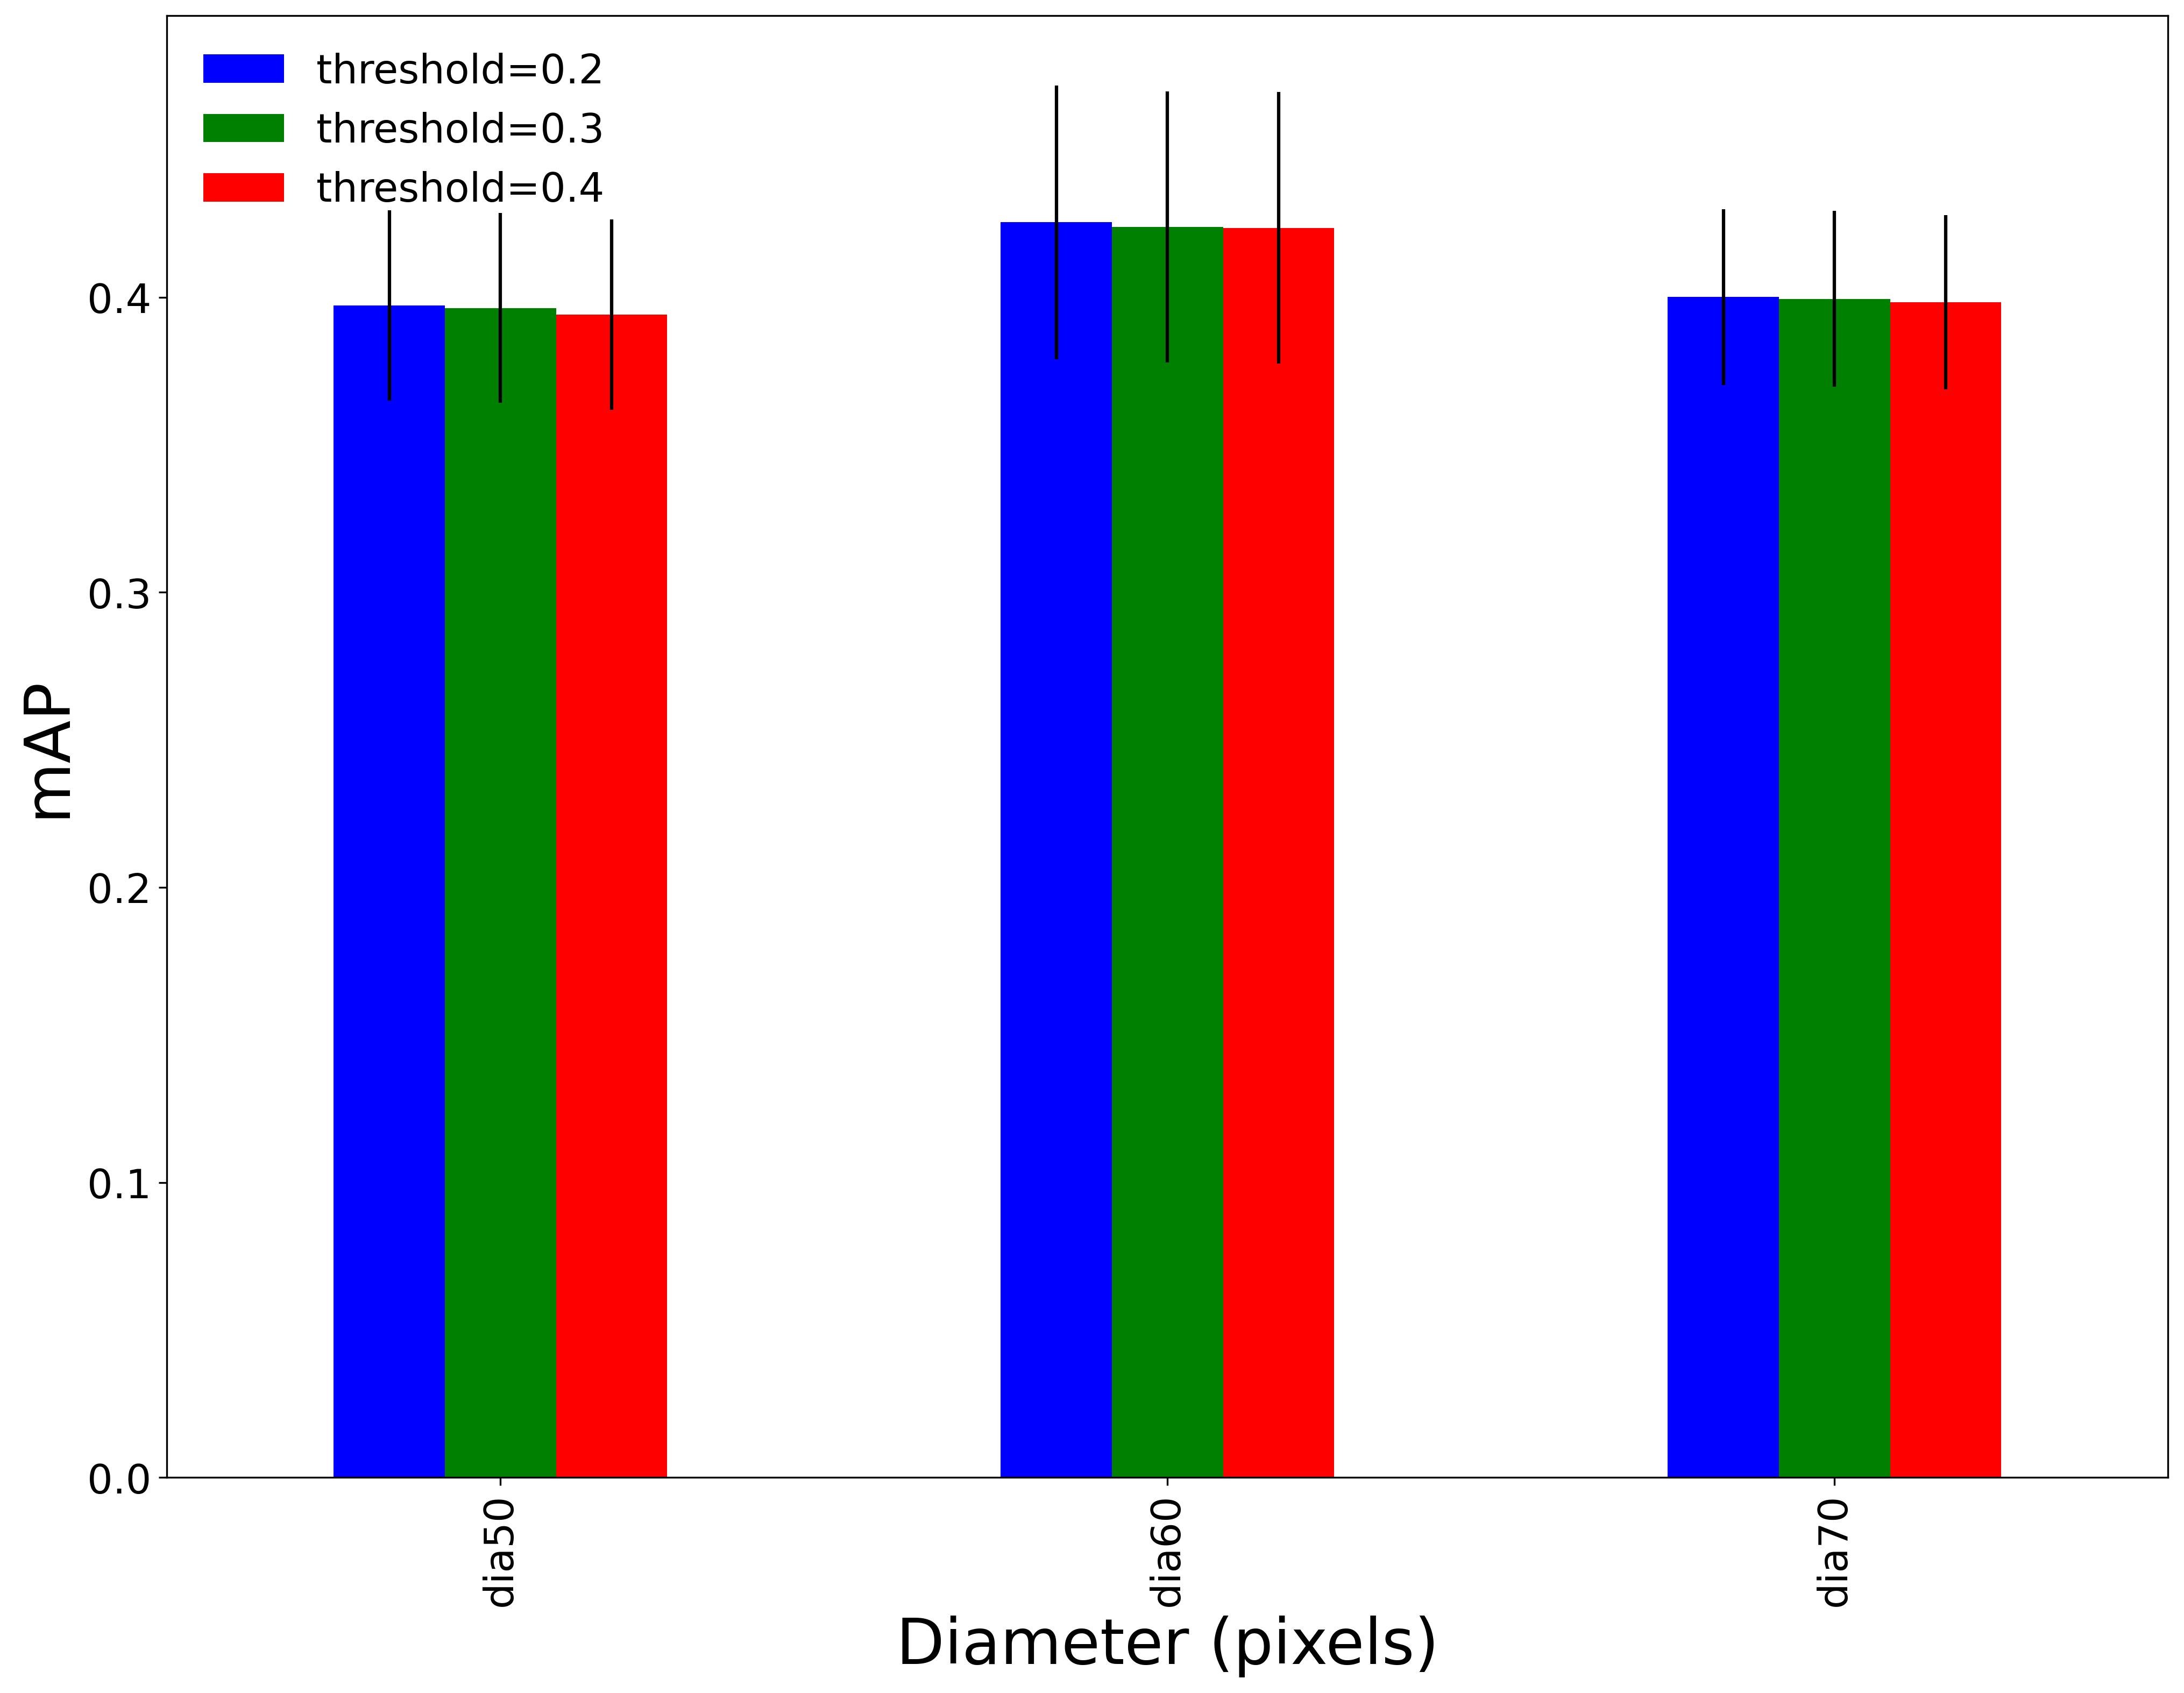

In [82]:


df = pd.DataFrame()

#the groups can vary 
grp1 = 'thre=0.2'
grp2 = 'thre=0.3'
grp3 = 'thre=0.4'


# df['label'] = ['dia10','dia20','dia25']

# df['label'] = ['dia40','dia50','dia60','dia70']
df['label'] = ['dia'+str(dia) for dia in dia_list]
# a = stat_mean[stat_mean['thre']=='0.075']['precision']
# a.head()
df[grp1+'_mean'] = stat_mean[stat_mean['thre']==0.2]['f1'].values
df[grp2+'_mean'] = stat_mean[stat_mean['thre']==0.3]['f1'].values
df[grp3+'_mean'] = stat_mean[stat_mean['thre']==0.4]['f1'].values


df[grp1+'_SE'] = stat_se[stat_se['thre']==0.2]['f1'].values
df[grp2+'_SE'] = stat_se[stat_se['thre']==0.3]['f1'].values
df[grp3+'_SE'] = stat_se[stat_se['thre']==0.4]['f1'].values

list_legend= ['threshold='+str(thre) for thre in thre_list]
fig,ax = plt.subplots(1,1, figsize=(16,12))

df.plot.bar(x='label', 
                y=[grp1+'_mean',grp2+'_mean',grp3+'_mean'],
                yerr=df[[grp1+'_SE',grp2+'_SE',grp3+'_SE']].T.values, ax=ax,color=['b','g','r','c','m','y','k'])


ax.legend(list_legend,loc='upper left',frameon=False,fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylabel('mAP',fontsize =28)
ax.set_xlabel('Diameter (pixels)',fontsize =28)

 # 2D

In [73]:
import pandas as pd
from skimage import measure
output_cellpose_2D = pd.DataFrame()


# thre_list = [0.5, 0.25,0.375,0.625,0.75]
dia_list = [50,60,70]
thre_list = [0.20,0.3,0.4]
# iou_thresholds = np.linspace(0.5,1,N_thresholds)
iou_thresholds = 0.5
#-0--------------------------------
seg_files = natsorted(glob.glob(data_folder + 'labels/*.tif*'))
test_seg_files = [f for i,f in enumerate(seg_files)]
# _, _,_, _, test_img_files, test_seg_files = split_dataset_5fold(data_folder, fold)
gt_files = test_seg_files
print('number of gt files',len(gt_files))
for dia in dia_list:
    for thre in thre_list:
        results_2d_cellpose_path =  data_folder + '/results_2d_cellpose_v2/mask*_thre_' +str(thre) + '_dia_'+str(dia) +'.tiff'
        results_2d_cellpose = natsorted(glob.glob(results_2d_cellpose_path))
        # print(len(results_2d_cellpose))
        if fold is not None and len(results_2d_cellpose)>2:
            results_2d_cellpose = [f for i,f in enumerate(results_2d_cellpose)]
        for file_idx in range(len(results_2d_cellpose)):
            print(results_2d_cellpose[file_idx],gt_files[file_idx])
            # break
            img_2d  = tifffile.imread(results_2d_cellpose[file_idx])
            gt_img = tifffile.imread(gt_files[file_idx])
            gt_img = measure.label(gt_img,background=0)
            res_match = matching(gt_img,img_2d,  thresh=0.5)


            df_temp = pd.DataFrame([res_match])
            df_temp['img_id'] = str(gt_files[file_idx].split('/')[-1])
            df_temp['thre'] = thre
            df_temp['dia'] =dia

            output_cellpose_2D = pd.concat([output_cellpose_2D,df_temp])


number of gt files 10
../../Nanolive_dataset//results_2d_cellpose_v2/mask_2%GA_RI_frame001_0_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/2%GA_RI_frame001_cp_masks_0_new.tiff
../../Nanolive_dataset//results_2d_cellpose_v2/mask_3_RI_time00h00m00s_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/3_RI_time00h00m00sws_mask_new_new.tiff
../../Nanolive_dataset//results_2d_cellpose_v2/mask_12_RI_time00h00m00s_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/12_RI_time00h00m00sws_mask_new.tiff
../../Nanolive_dataset//results_2d_cellpose_v2/mask_15_RI_time00h00m00s_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/15_RI_time00h00m00sws_mask_new.tiff
../../Nanolive_dataset//results_2d_cellpose_v2/mask_16_RI_time00h00m00s_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/16_RI_time00h00m00sws_mask_new.tiff
../../Nanolive_dataset//results_2d_cellpose_v2/mask_17_RI_time00h00m00s_thre_0.2_dia_50.tiff ../../Nanolive_dataset/labels/17_RI_time00h00m00sws_mask_new.tiff
../../Nanolive_dataset

Text(0.5, 0, 'Diameter (pixels)')

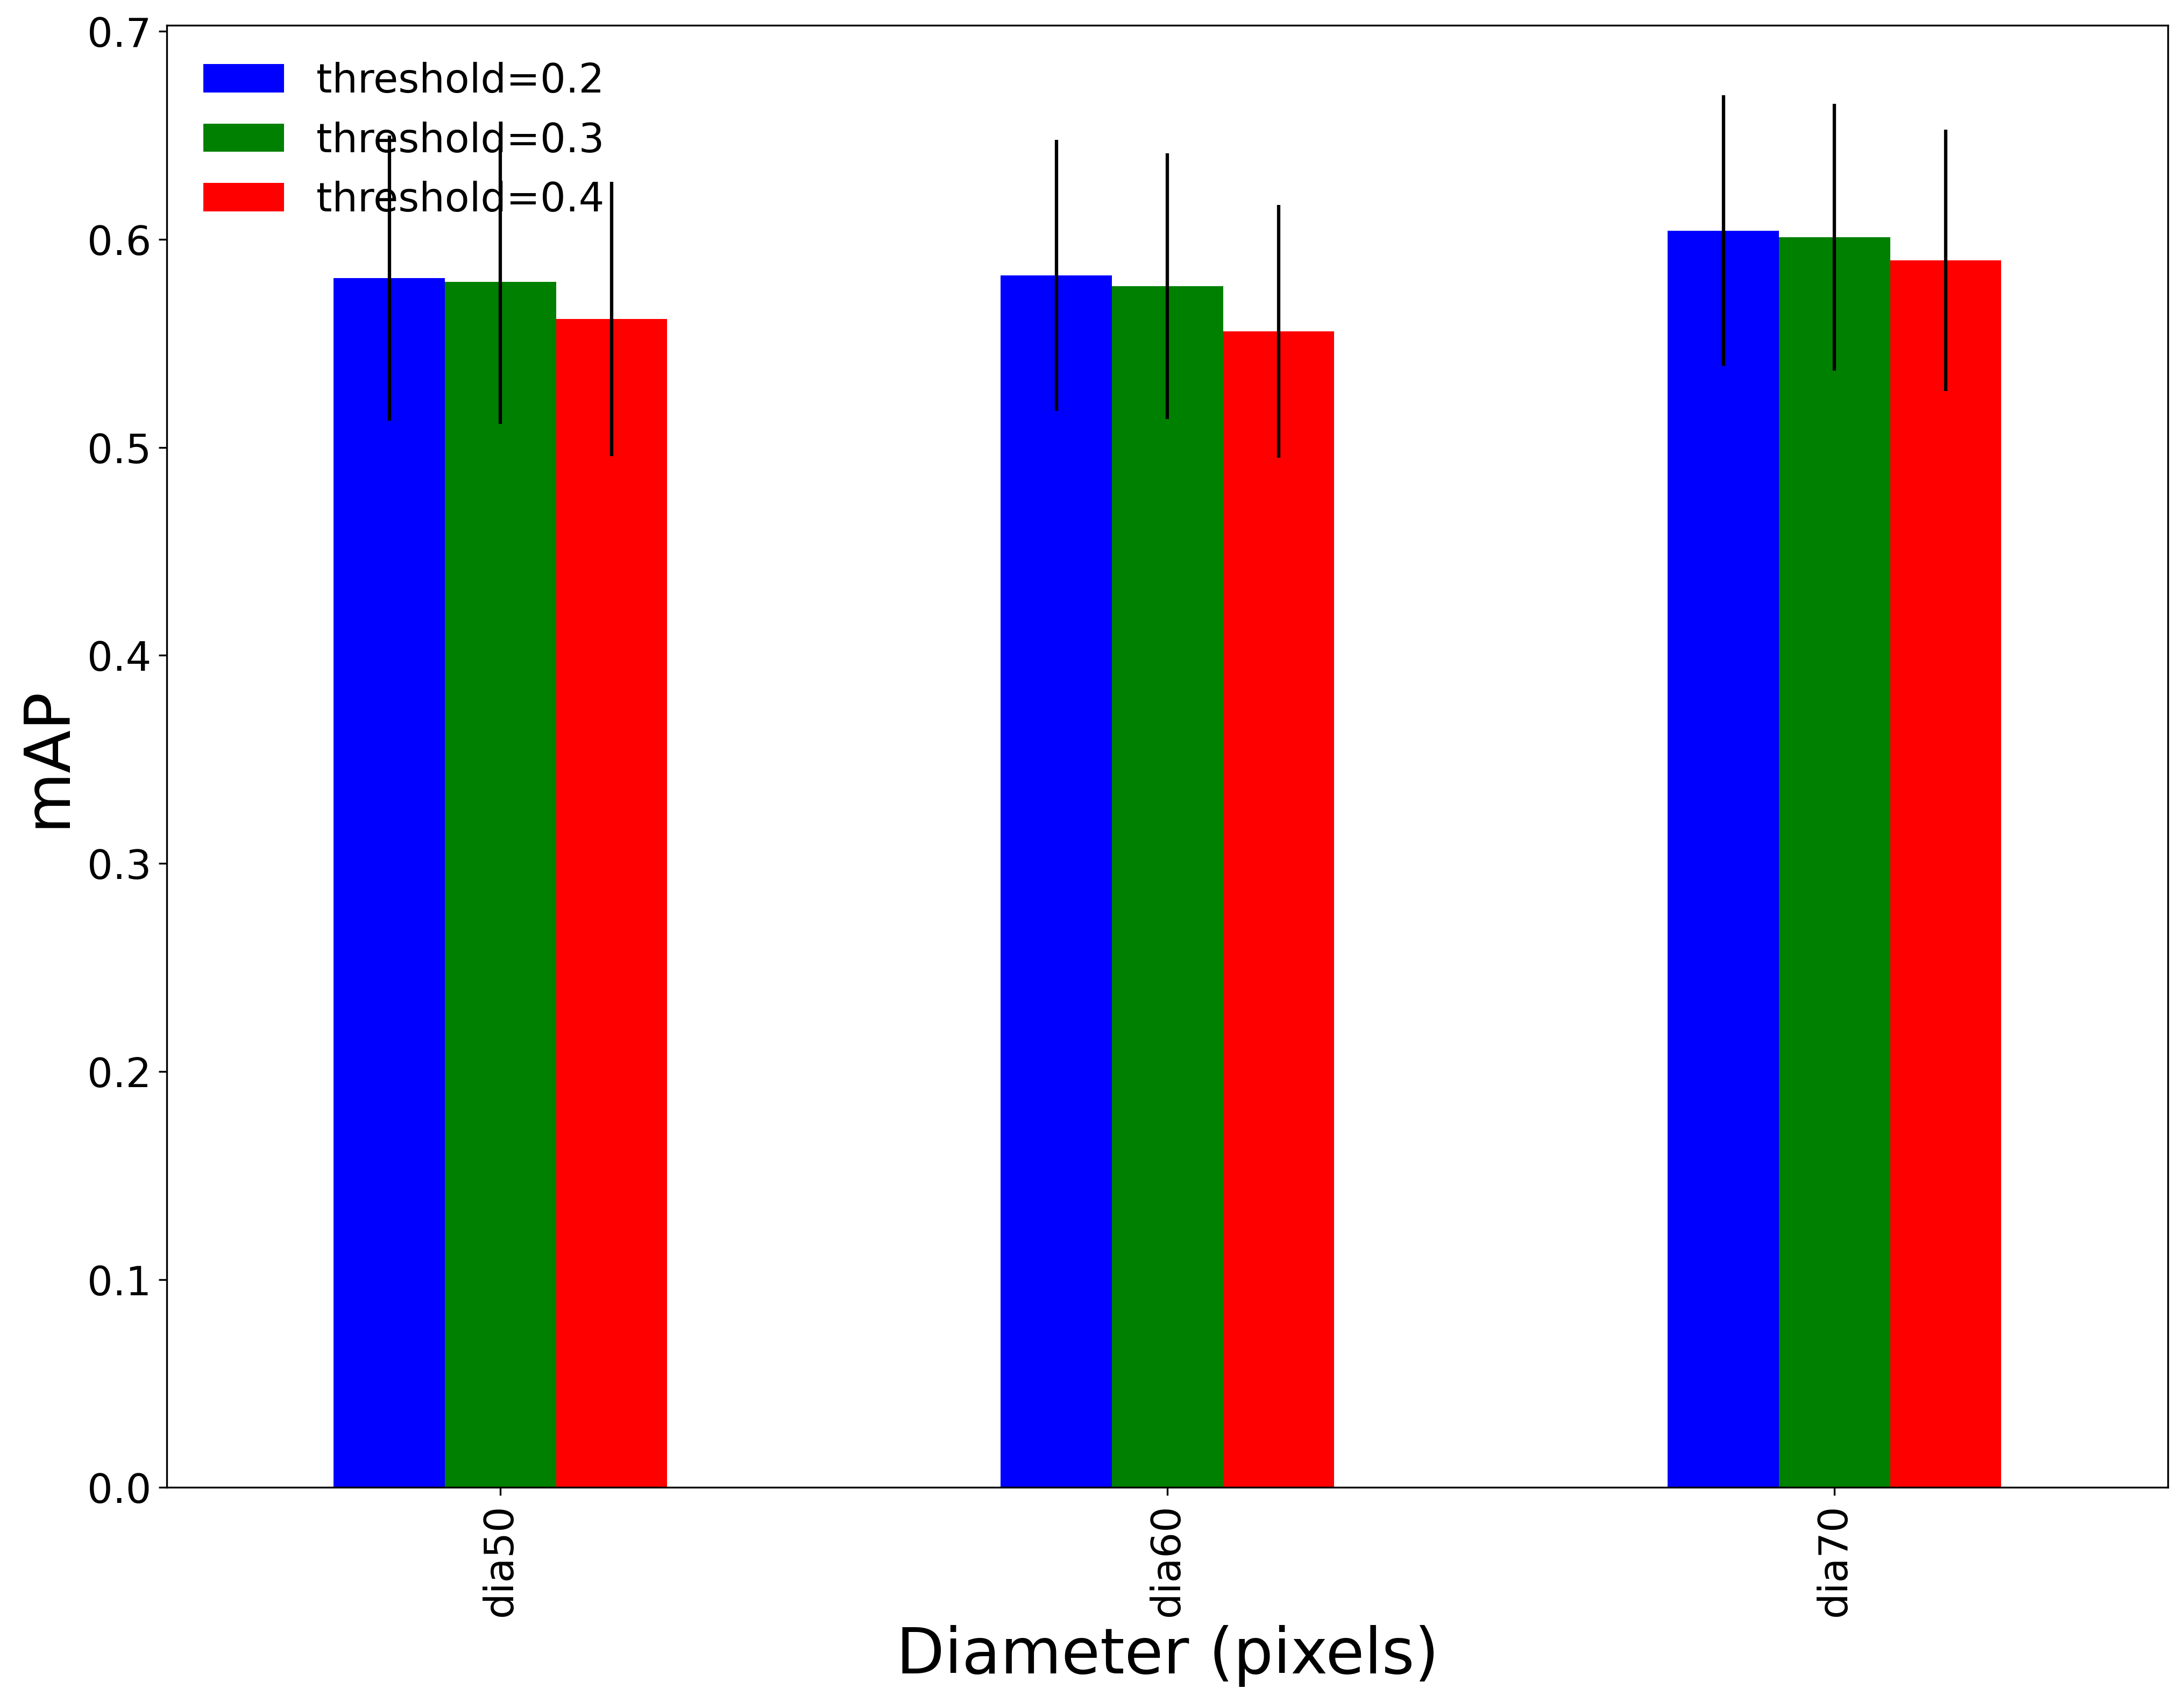

In [74]:
stat_mean =output_cellpose_2D.groupby(['dia','thre']).mean().reset_index()
stat_se =output_cellpose_2D.groupby(['dia','thre']).sem().reset_index()

df = pd.DataFrame()

#the groups can vary 
grp1 = 'thre=0.2'
grp2 = 'thre=0.3'
grp3 = 'thre=0.4'


# df['label'] = ['dia10','dia20','dia25']

# df['label'] = ['dia40','dia50','dia60','dia70']
df['label'] = ['dia'+str(dia) for dia in dia_list]
# a = stat_mean[stat_mean['thre']=='0.075']['precision']
# a.head()
df[grp1+'_mean'] = stat_mean[stat_mean['thre']==0.2]['f1'].values
df[grp2+'_mean'] = stat_mean[stat_mean['thre']==0.3]['f1'].values
df[grp3+'_mean'] = stat_mean[stat_mean['thre']==0.4]['f1'].values


df[grp1+'_SE'] = stat_se[stat_se['thre']==0.2]['f1'].values
df[grp2+'_SE'] = stat_se[stat_se['thre']==0.3]['f1'].values
df[grp3+'_SE'] = stat_se[stat_se['thre']==0.4]['f1'].values

list_legend= ['threshold='+str(thre) for thre in thre_list]
fig,ax = plt.subplots(1,1, figsize=(16,12))

df.plot.bar(x='label', 
                y=[grp1+'_mean',grp2+'_mean',grp3+'_mean'],
                yerr=df[[grp1+'_SE',grp2+'_SE',grp3+'_SE']].T.values, ax=ax,color=['b','g','r','c','m','y','k'])


ax.legend(list_legend,loc='upper left',frameon=False,fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylabel('mAP',fontsize =28)
ax.set_xlabel('Diameter (pixels)',fontsize =28)